# Cài đặt

In [ ]:
!pip install vnstock

In [ ]:
!pip install -r sample_data/requirements.txt # Cài đặt các gói phụ thuộc nếu việc tự động cài đặt không thành công

# Dữ liệu

In [ ]:
from vnstock import Vnstock

stock = Vnstock().stock(symbol='ACB', source='VCI')

2025-01-23 06:31:00 - vnstock.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [ ]:
# Data cổ phiếu
df = stock.quote.history(start='2024-01-01', end='2024-06-21', interval='1D')
df

,time,open,high,low,close,volume
0,2024-01-02,20.12,20.79,20.12,20.54,13896933
1,2024-01-03,20.58,21.00,20.37,21.00,9817807
2,2024-01-04,21.17,21.55,21.08,21.25,23605373
3,2024-01-05,21.25,21.38,21.04,21.38,9282598
4,2024-01-08,21.59,21.63,21.17,21.29,12398885
...,...,...,...,...,...,...
110,2024-06-17,24.60,24.60,24.25,24.55,6375848
111,2024-06-18,24.70,24.70,24.40,24.55,5729760
112,2024-06-19,24.55,24.70,24.25,24.65,7618993
113,2024-06-20,24.55,24.85,24.40,24.80,10178313


## Arima

In [ ]:
# Arima
!pip install statsmodels pandas matplotlib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

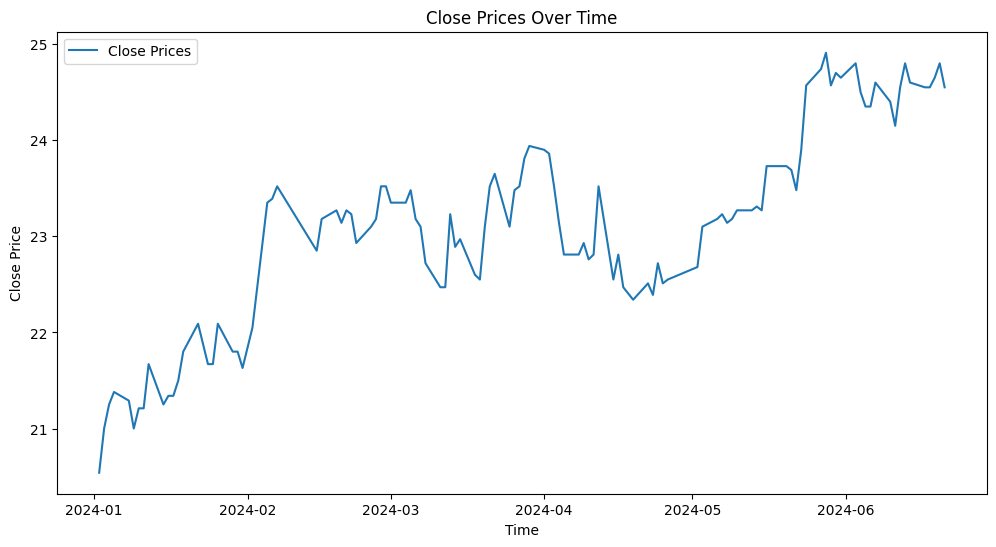

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Close Prices')
plt.title('Close Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# Vì cái Arima này yêu cầu dữ liệu dừng nên phải thực hiện kiểm định Augmented Dickey-Fuller
result = adfuller(df['close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary. Differencing is required.")

ADF Statistic: -2.2332601209389176
p-value: 0.19439611407752544
The data is not stationary. Differencing is required.


In [ ]:
# Tính cho về dữ liệu dừng
df['close_diff'] = df['close'].diff().dropna()

# Kiểm tra lần nữa
result_diff = adfuller(df['close_diff'].dropna())
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -8.139818441133933
p-value (Differenced): 1.0354036008652486e-12


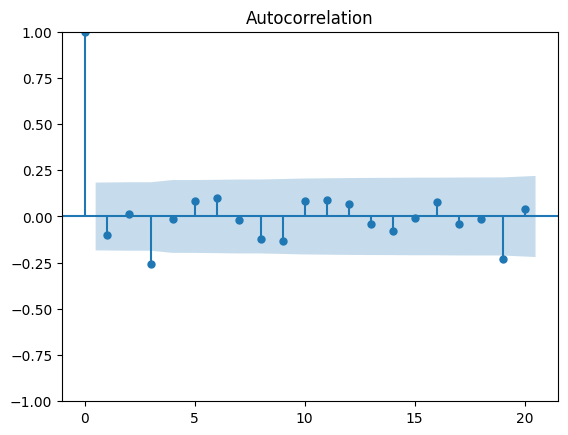

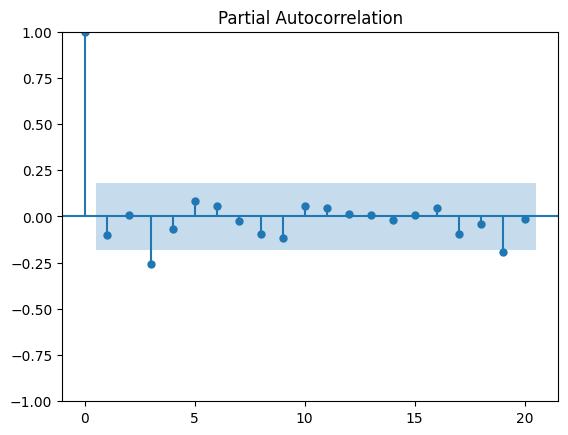

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  115
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -24.710
Date:                Thu, 23 Jan 2025   AIC                             55.420
Time:                        06:40:26   BIC                             63.628
Sample:                             0   HQIC                            58.751
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8084      0.269     -3.006      0.003      -1.336      -0.281
ma.L1          0.7281      0.306      2.380      0.017       0.128       1.328
sigma2         0.0903      0.009     10.571      0.0

In [ ]:
# Vẽ ACF & PACF
plot_acf(df['close_diff'].dropna(), lags=20)
plot_pacf(df['close_diff'].dropna(), lags=20)
plt.show()

# Fit ARIMA
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['close'], order=(1, 1, 1))  # Adjust p, d, q as needed
model_fit = model.fit()

print(model_fit.summary())

## Dự báo giá trong tương lai

No supported index is available. Prediction results will be given with an integer index beginning at `start`.
No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.


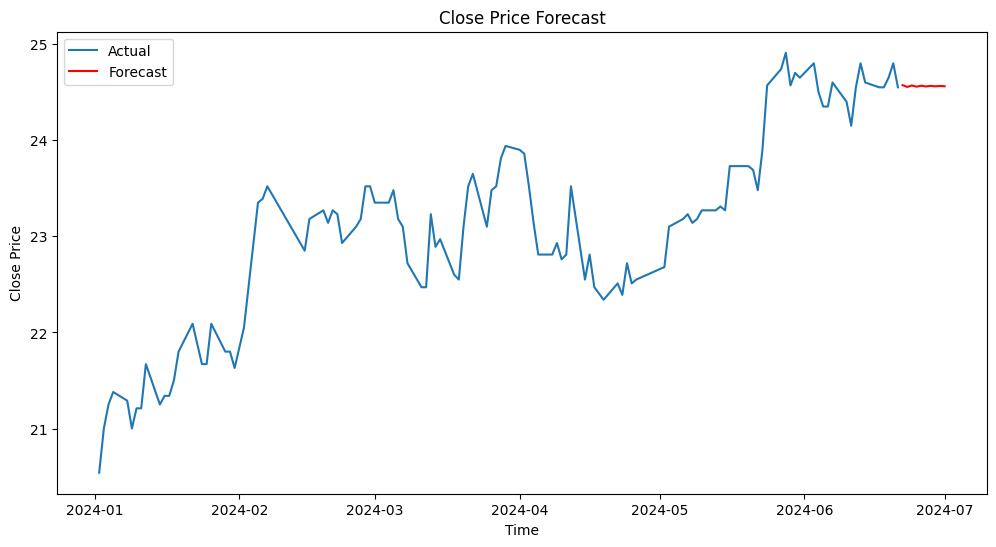

In [ ]:
# Đoán 10 ngày tiếp
forecast = model_fit.forecast(steps=10)

# Tạo khoảng cho nó
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=10)

# Tích hợp data
forecast_df = pd.DataFrame({'time': future_dates, 'forecast': forecast})
forecast_df.set_index('time', inplace=True)

# Vẽ
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Actual')
plt.plot(forecast_df['forecast'], label='Forecast', color='red')
plt.title('Close Price Forecast')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()